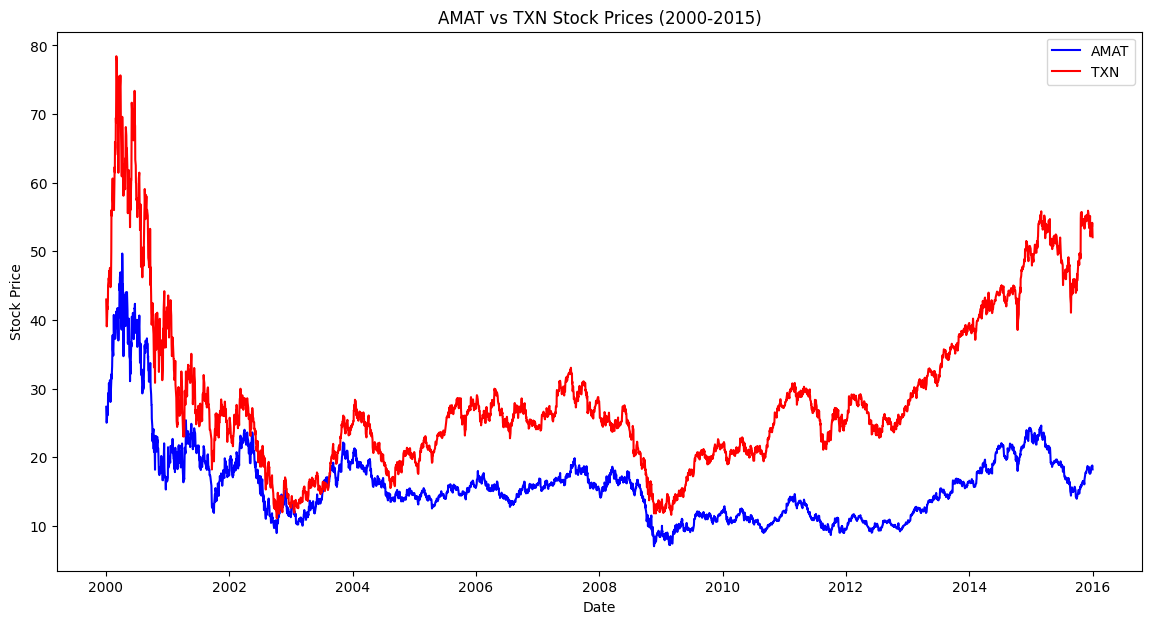

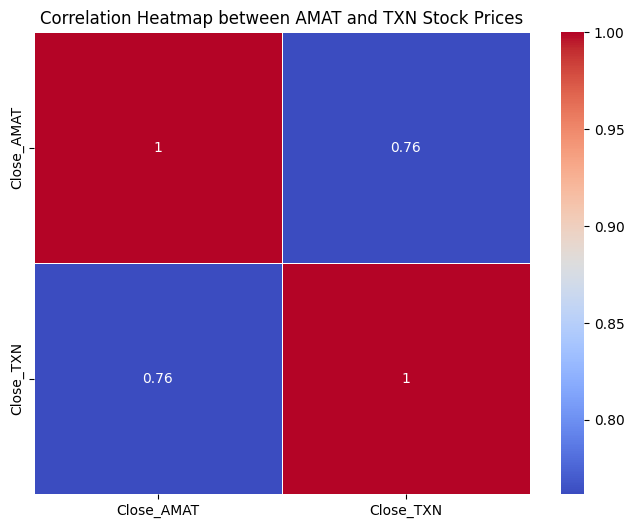

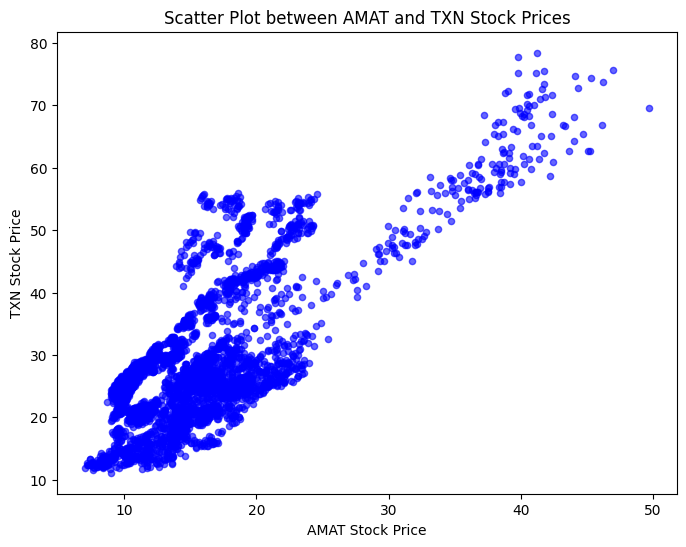

Mean Squared Error: 100.87889605303904


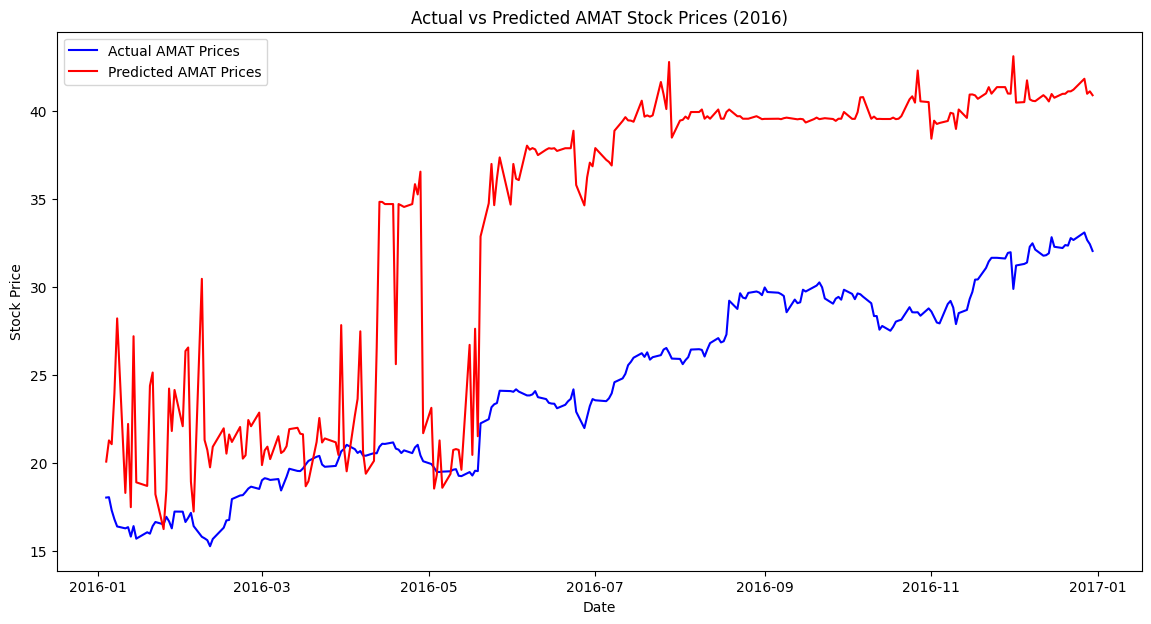

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

file_amat = './amat.us.csv'
file_txn = './txn.us.csv'

data_a = pd.read_csv(file_amat)
data_t = pd.read_csv(file_txn)

data_a['Date'] = pd.to_datetime(data_a['Date'])
data_t['Date'] = pd.to_datetime(data_t['Date'])

start_date = '2000-01-01'
end_date = '2015-12-31'
training_data_a = data_a[(data_a['Date'] >= start_date) & (data_a['Date'] <= end_date)]
training_data_t = data_t[(data_t['Date'] >= start_date) & (data_t['Date'] <= end_date)]

test_start_date = '2016-01-01'
test_end_date = '2017-01-01'
test_data_a = data_a[(data_a['Date'] >= test_start_date) & (data_a['Date'] <= test_end_date)]
test_data_t = data_t[(data_t['Date'] >= test_start_date) & (data_t['Date'] <= test_end_date)]

# データの一致を確認するために、共通の日付を取得する
common_dates = set(training_data_a['Date']).intersection(set(training_data_t['Date']))
training_data_a = training_data_a[training_data_a['Date'].isin(common_dates)]
training_data_t = training_data_t[training_data_t['Date'].isin(common_dates)]

plt.figure(figsize=(14, 7))
plt.plot(training_data_a['Date'], training_data_a['Close'], label='AMAT', color='b')
plt.plot(training_data_t['Date'], training_data_t['Close'], label='TXN', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMAT vs TXN Stock Prices (2000-2015)')
plt.legend()
plt.show()

merged_data = pd.merge(training_data_a[['Date', 'Close']], training_data_t[['Date', 'Close']], on='Date', suffixes=('_AMAT', '_TXN'))
correlation_matrix = merged_data[['Close_AMAT', 'Close_TXN']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap between AMAT and TXN Stock Prices')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(merged_data['Close_AMAT'], merged_data['Close_TXN'], alpha=0.6, c='b', s=20)
plt.xlabel('AMAT Stock Price')
plt.ylabel('TXN Stock Price')
plt.title('Scatter Plot between AMAT and TXN Stock Prices')
plt.show()

X_train = training_data_t[['Close', 'Volume']]
y_train = training_data_a['Close']

common_test_dates = set(test_data_a['Date']).intersection(set(test_data_t['Date']))
test_data_a = test_data_a[test_data_a['Date'].isin(common_test_dates)]
test_data_t = test_data_t[test_data_t['Date'].isin(common_test_dates)]

X_test = test_data_t[['Close', 'Volume']]
y_test = test_data_a['Close']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(14, 7))
plt.plot(test_data_a['Date'], y_test, label='Actual AMAT Prices', color='b')
plt.plot(test_data_a['Date'], y_pred, label='Predicted AMAT Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted AMAT Stock Prices (2016)')
plt.legend()
plt.show()


Mean Squared Error: 81.0529204526899


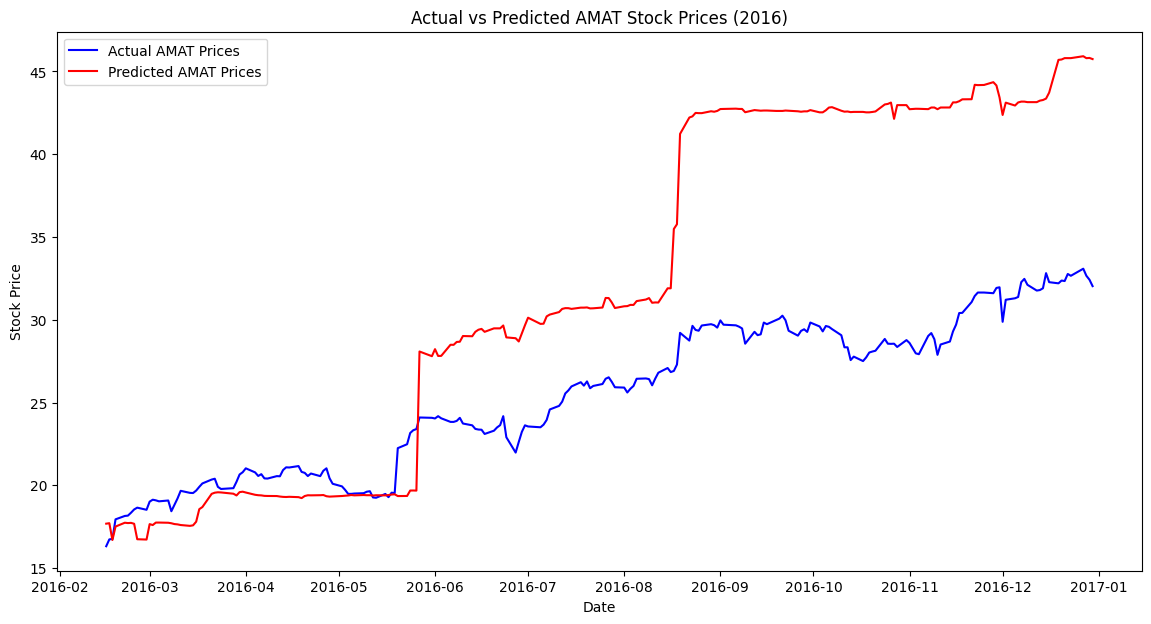

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# データの読み込み
file_amat = './amat.us.csv'
file_txn = './txn.us.csv'

data_a = pd.read_csv(file_amat)
data_t = pd.read_csv(file_txn)

data_a['Date'] = pd.to_datetime(data_a['Date'])
data_t['Date'] = pd.to_datetime(data_t['Date'])

start_date = '2000-01-01'
end_date = '2015-12-31'
training_data_a = data_a[(data_a['Date'] >= start_date) & (data_a['Date'] <= end_date)].dropna()
training_data_t = data_t[(data_t['Date'] >= start_date) & (data_t['Date'] <= end_date)].dropna()

test_start_date = '2016-01-01'
test_end_date = '2017-01-01'
test_data_a = data_a[(data_a['Date'] >= test_start_date) & (data_a['Date'] <= test_end_date)].dropna()
test_data_t = data_t[(data_t['Date'] >= test_start_date) & (data_t['Date'] <= test_end_date)].dropna()

# 過去の株価情報の統計量を計算する関数
def add_past_statistics(data, window=30):
    data[f'Close_mean_{window}'] = data['Close'].rolling(window=window).mean()
    data[f'Close_max_{window}'] = data['Close'].rolling(window=window).max()
    data[f'Close_min_{window}'] = data['Close'].rolling(window=window).min()
    return data

# 訓練データに過去の統計量を追加
training_data_a = add_past_statistics(training_data_a)
training_data_t = add_past_statistics(training_data_t)

# テストデータに過去の統計量を追加
test_data_a = add_past_statistics(test_data_a)
test_data_t = add_past_statistics(test_data_t)

# 訓練データを共通の日付でマージする
merged_training_data = pd.merge(training_data_a[['Date', 'Close', f'Close_mean_{30}', f'Close_max_{30}', f'Close_min_{30}']], 
                                training_data_t[['Date', 'Close', 'Volume', f'Close_mean_{30}', f'Close_max_{30}', f'Close_min_{30}']], 
                                on='Date', suffixes=('_AMAT', '_TXN')).dropna()

X_train = merged_training_data.drop(columns=['Date', 'Close_AMAT'])
y_train = merged_training_data['Close_AMAT']

# テストデータを共通の日付でマージする
merged_test_data = pd.merge(test_data_a[['Date', 'Close', f'Close_mean_{30}', f'Close_max_{30}', f'Close_min_{30}']], 
                            test_data_t[['Date', 'Close', 'Volume', f'Close_mean_{30}', f'Close_max_{30}', f'Close_min_{30}']], 
                            on='Date', suffixes=('_AMAT', '_TXN')).dropna()

X_test = merged_test_data.drop(columns=['Date', 'Close_AMAT'])
y_test = merged_test_data['Close_AMAT']

# ランダムフォレストのハイパーパラメータチューニング
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# テストデータで予測する
y_pred = best_model.predict(X_test)

# モデルの精度を測定する
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 予測結果をプロットする
plt.figure(figsize=(14, 7))
plt.plot(merged_test_data['Date'], y_test, label='Actual AMAT Prices', color='b')
plt.plot(merged_test_data['Date'], y_pred, label='Predicted AMAT Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted AMAT Stock Prices (2016)')
plt.legend()
plt.show()



Mean Squared Error: 100.87889605303904


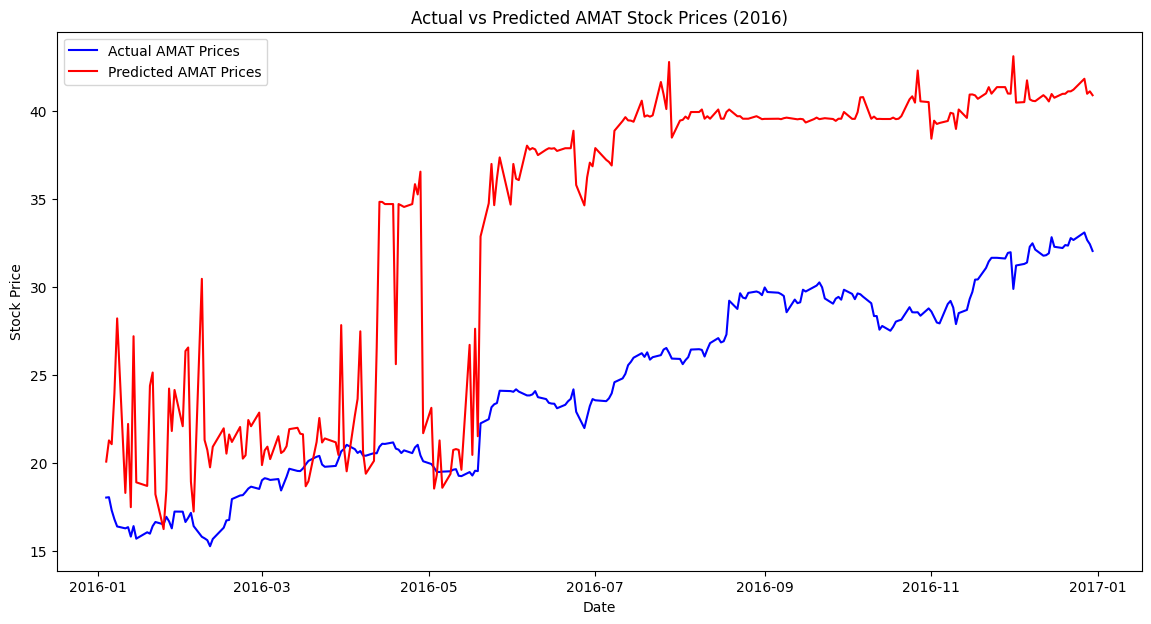

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# データの読み込み
file_amat = './amat.us.csv'
file_txn = './txn.us.csv'

data_a = pd.read_csv(file_amat)
data_t = pd.read_csv(file_txn)

data_a['Date'] = pd.to_datetime(data_a['Date'])
data_t['Date'] = pd.to_datetime(data_t['Date'])

start_date = '2000-01-01'
end_date = '2015-12-31'
training_data_a = data_a[(data_a['Date'] >= start_date) & (data_a['Date'] <= end_date)].dropna()
training_data_t = data_t[(data_t['Date'] >= start_date) & (data_t['Date'] <= end_date)].dropna()

test_start_date = '2016-01-01'
test_end_date = '2017-01-01'
test_data_a = data_a[(data_a['Date'] >= test_start_date) & (data_a['Date'] <= test_end_date)].dropna()
test_data_t = data_t[(data_t['Date'] >= test_start_date) & (data_t['Date'] <= test_end_date)].dropna()

# 訓練データを共通の日付でマージする
merged_training_data = pd.merge(training_data_a[['Date', 'Close']], 
                                training_data_t[['Date', 'Close', 'Volume']], 
                                on='Date', suffixes=('_AMAT', '_TXN')).dropna()

X_train = merged_training_data[['Close_TXN', 'Volume']]
y_train = merged_training_data['Close_AMAT']

# テストデータを共通の日付でマージする
merged_test_data = pd.merge(test_data_a[['Date', 'Close']], 
                            test_data_t[['Date', 'Close', 'Volume']], 
                            on='Date', suffixes=('_AMAT', '_TXN')).dropna()

X_test = merged_test_data[['Close_TXN', 'Volume']]
y_test = merged_test_data['Close_AMAT']

# ランダムフォレストモデルを訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータで予測する
y_pred = model.predict(X_test)

# モデルの精度を測定する
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 予測結果をプロットする
plt.figure(figsize=(14, 7))
plt.plot(merged_test_data['Date'], y_test, label='Actual AMAT Prices', color='b')
plt.plot(merged_test_data['Date'], y_pred, label='Predicted AMAT Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted AMAT Stock Prices (2016)')
plt.legend()
plt.show()


Mean Squared Error: 0.10829434972658984


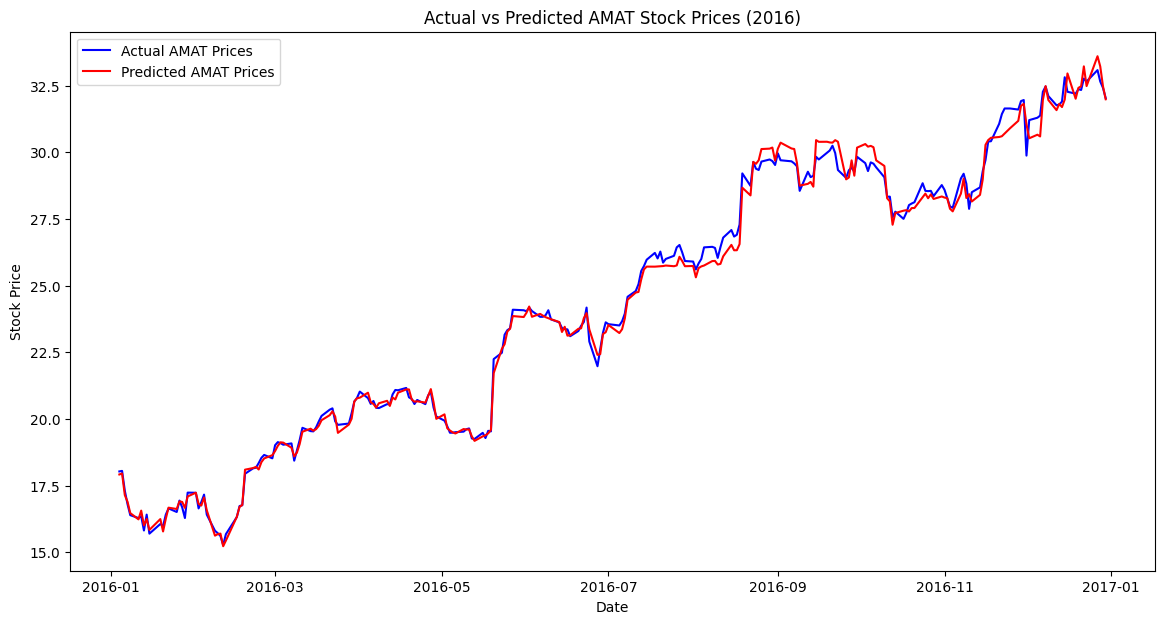

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# データの読み込み
file_amat = './amat.us.csv'

data_a = pd.read_csv(file_amat)

data_a['Date'] = pd.to_datetime(data_a['Date'])

start_date = '2000-01-01'
end_date = '2015-12-31'
training_data_a = data_a[(data_a['Date'] >= start_date) & (data_a['Date'] <= end_date)].dropna()

test_start_date = '2016-01-01'
test_end_date = '2017-01-01'
test_data_a = data_a[(data_a['Date'] >= test_start_date) & (data_a['Date'] <= test_end_date)].dropna()

# 特徴量とターゲットを設定
X_train = training_data_a[['Open', 'High', 'Low', 'Volume']]
y_train = training_data_a['Close']

X_test = test_data_a[['Open', 'High', 'Low', 'Volume']]
y_test = test_data_a['Close']

# ランダムフォレストモデルを訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータで予測する
y_pred = model.predict(X_test)

# モデルの精度を測定する
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 予測結果をプロットする
plt.figure(figsize=(14, 7))
plt.plot(test_data_a['Date'], y_test, label='Actual AMAT Prices', color='b')
plt.plot(test_data_a['Date'], y_pred, label='Predicted AMAT Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted AMAT Stock Prices (2016)')
plt.legend()
plt.show()


X_train:
[[2.7765000e+01 2.7765000e+01 2.6242000e+01 1.6621747e+07]
 [2.6328000e+01 2.7081000e+01 2.5948000e+01 2.6400939e+07]
 [2.5524000e+01 2.5992000e+01 2.4575000e+01 3.2151166e+07]
 ...
 [1.8562000e+01 1.8954000e+01 1.8562000e+01 1.1142428e+07]
 [1.8641000e+01 1.8895000e+01 1.8494000e+01 5.4187180e+06]
 [1.8494000e+01 1.8514000e+01 1.8232000e+01 7.3771130e+06]]
y_train:
[27.35  26.002 25.032 ... 18.806 18.514 18.232]
X_test:
[[1.7880000e+01 1.8035000e+01 1.7777000e+01 1.2593544e+07]
 [1.8035000e+01 1.8187000e+01 1.7862000e+01 8.5137060e+06]
 [1.7742000e+01 1.7802000e+01 1.6834000e+01 2.7295389e+07]
 ...
 [3.3303000e+01 3.3432000e+01 3.2638000e+01 5.2410280e+06]
 [3.2559000e+01 3.2746000e+01 3.2241000e+01 4.2920900e+06]
 [3.2619000e+01 3.2667000e+01 3.1943000e+01 5.9314410e+06]]
y_test:
[18.035 18.055 17.313 16.805 16.395 16.287 16.355 15.819 16.415 15.702
 16.064 15.985 16.415 16.648 16.514 16.942 16.688 16.287 17.24  17.235
 16.648 16.884 17.166 16.415 15.809 15.721 15.615 15.273

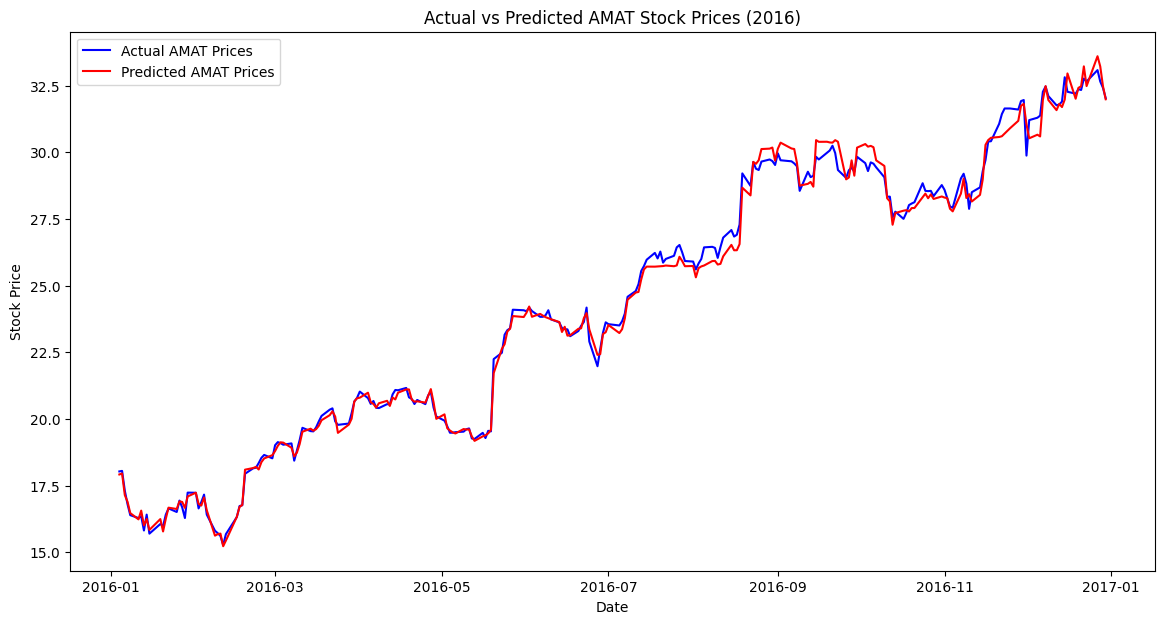

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from google.colab import drive
drive.mount('/content/drive')

# Googleドライブのパスを指定
file_amat = '/content/drive/My Drive/path_to_your_file/amat.us.csv'

# データの読み込み
# file_amat = './amat.us.csv'
data_a = pd.read_csv(file_amat)

# 日付をdatetime型に変換
data_a['Date'] = pd.to_datetime(data_a['Date'])

# 訓練データとテストデータに分割
start_date = '2000-01-01'
end_date = '2015-12-31'
training_data_a = data_a[(data_a['Date'] >= start_date) & (data_a['Date'] <= end_date)].dropna()

test_start_date = '2016-01-01'
test_end_date = '2017-01-01'
test_data_a = data_a[(data_a['Date'] >= test_start_date) & (data_a['Date'] <= test_end_date)].dropna()

# 特徴量とターゲットを設定
# NumPy配列に変換
X_train = training_data_a[['Open', 'High', 'Low', 'Volume']].values  
# NumPy配列に変換
y_train = training_data_a['Close'].values 

X_test = test_data_a[['Open', 'High', 'Low', 'Volume']].values  # NumPy配列に変換
y_test = test_data_a['Close'].values  # NumPy配列に変換

# NumPy配列の中身を出力
print("X_train:")
print(X_train)
print("y_train:")
print(y_train)
print("X_test:")
print(X_test)
print("y_test:")
print(y_test)

# ランダムフォレストモデルを訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータで予測する
y_pred = model.predict(X_test)

# モデルの精度を測定する
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 予測結果をプロットする
plt.figure(figsize=(14, 7))
plt.plot(test_data_a['Date'], y_test, label='Actual AMAT Prices', color='b')
plt.plot(test_data_a['Date'], y_pred, label='Predicted AMAT Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted AMAT Stock Prices (2016)')
plt.legend()
plt.show()
